 ## Import bibliotek

In [1]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import numpy as np
import math
from tqdm import tqdm

import xgboost as xgb
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
import re
import eli5

import matplotlib.pyplot as plt

np.random.seed(0)

## Pobieranie i łączenie danych

In [2]:
df_train = pd.read_hdf("../input/df.train.h5")
df_test = pd.read_hdf("../input/df.test.h5")
print(df_train.shape, df_test.shape)

(80129, 10) (80129, 7)


In [3]:
df_train.sample(5)

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params
8536,8536,Cena Brutto,26 500,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Pawłów, starachowicki, Świętokrzyskie","[Osobowe, Suzuki, Grand Vitara, Suzuki Grand V...","{'Kolor': 'Srebrny', 'Model pojazdu': 'Grand V..."
27573,27573,"Cena Netto, Faktura VAT",24 389,PLN,"[ABS, Centralny zamek, Elektrycznie ustawiane ...",AAA AUTO - aż 1000 samochodów w ofercie! do 24...,Dealer,"Okulickiego 3B - 05-500 Piaseczno, piaseczyńsk...","[Osobowe, Opel, Corsa, Opel Corsa D (2006-2014)]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ..."
4556,4556,Cena Brutto,9 900,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",FHU OLKAR,Dealer,"ul. LEŚNA 19B - 87-148 Łysomice, toruński, Kuj...","[Osobowe, Nissan, Primera, Nissan Primera P12 ...","{'Liczba miejsc': '5', 'Pojemność skokowa': '2..."
34165,34165,Cena Brutto,16 500,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",LUCKY - SALON SAMOCHODÓW UŻYWANYCH Z GWARANCJ...,Dealer,"Konstytucji 117 - 41-906 Bytom, Śląskie (Polska)","[Osobowe, Toyota, Yaris, Toyota Yaris II (2005...","{'Liczba miejsc': '5', 'Kraj pochodzenia': 'Ni..."
26021,26021,"Cena Brutto, Do negocjacji",5 800,PLN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",AGIER-CARS,Dealer,"SZEROKA 25 - 95-030 Starowa Góra, łódzki wscho...","[Osobowe, Peugeot, 206]","{'Kolor': 'Srebrny', 'Model pojazdu': '206', '..."


## funkcje

In [4]:
def check_log_model(df, feats, model, cv=5, scoring=mean_absolute_error, show_eli5=True):
    df_train = df[ ~df["price_value"].isnull() ].copy()
    
    X = df_train[feats]
    y = df_train["price_value"]
    y_log = np.log(y)
    
    cv = KFold(n_splits=cv, shuffle=True, random_state=0)
    scores=[]
    for train_idx, test_idx in tqdm(cv.split(X)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_log_train, y_test = y_log.iloc[train_idx], y.iloc[test_idx]
        
        model.fit(X_train, y_log_train)
        y_log_pred = model.predict(X_test)
        y_pred = np.exp(y_log_pred)
        
        score = scoring(y_test, y_pred)
        scores.append(score)
        
    result = np.mean(scores), np.std(scores)
    
    if show_eli5:
        model.fit(X, y_log)
        print(result)
        return eli5.show_weights(model, feature_names=feats)
    
    return result

## zmienna docelowa

In [5]:
df_train["price_value"] = df_train["price_value"].map(lambda x: x.replace(" ", "").replace(",",".") if type(x)==str else x).astype(float)

In [6]:
df_train[df_train["price_value"]>100000000]

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params
106447,106447,Cena Brutto,9999999999999.000,PLN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",None,Osoba prywatna,"Lubań, lubański, Dolnośląskie","[Osobowe, Honda, Jazz, Honda Jazz IV (2015-)]","{'Pojemność skokowa': '9 999 cm3', 'Model poja..."


In [7]:
if len(df_train[df_train["price_value"]>100000000]) >0:
    df_train = df_train.drop(index=106447)
    df_train = df_train.reset_index(drop=True)
    
df_train[df_train["price_value"]>100000000]

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params


<AxesSubplot:>

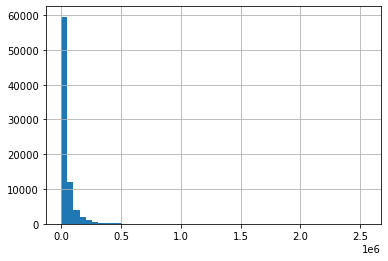

In [8]:
df_train["price_value"].hist(bins=50)

<AxesSubplot:>

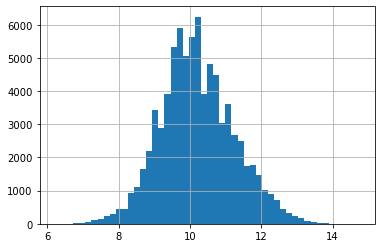

In [9]:
df_train["price_value_log"] = df_train["price_value"].map(lambda x: math.log(x))
df_train['price_value_log'].hist(bins=50)

## połączenie train i test

In [10]:
df = pd.concat([df_train, df_test])
df = df.reset_index(drop=True)

## Generowanie Cech

In [11]:
offer_params = df["offer_params"].apply(pd.Series)
offer_params = offer_params.fillna(-1)

if "Bezwypadkowy" not in df:
    df = pd.concat([df, offer_params], axis=1)
    
df.sample(5)

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,price_value_log,Bezwypadkowy,Liczba miejsc,Kraj pochodzenia,Pojemność skokowa,Rodzaj paliwa,Skrzynia biegów,Możliwość finansowania,Pierwszy właściciel,Oferta od,Liczba drzwi,Przebieg,Moc,Metalik,Typ,Kolor,Model pojazdu,Stan,Kategoria,Serwisowany w ASO,Napęd,Leasing,Rok produkcji,Marka pojazdu,Faktura VAT,Pierwsza rejestracja,Zarejestrowany w Polsce,VAT marża,Wersja,VIN,Perłowy,Uszkodzony,Kod Silnika,Filtr cząstek stałych,Emisja CO2,Miesięczna rata,Liczba pozostałych rat,Opłata początkowa,Wartość wykupu,Akryl (niemetalizowany),Tuning,Kierownica po prawej (Anglik),Homologacja ciężarowa,Make,Metallic,Engine capacity,Version,VAT discount,No accident,Mileage,Service record,Door count,Fuel type,Nr of seats,Gearbox,Transmission,Engine power,Model,Color,Country of origin,Body type,Year,Matowy,Acrylic,Financing option,Registered in Poland,Original owner,First registration,Pearl,Zarejestrowany jako zabytek,VAT free,Engine Code,Particle filter,Leasing concession,Damaged,CO2 emissions,Monthly payment value
81259,2278,NaN,nan,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Tarnów, Małopolskie","[Osobowe, Hyundai, i20, Hyundai i20 II (2014-)]","{'Pojemność skokowa': '1 248 cm3', 'Model poja...",nan,-1,5,-1,1 248 cm3,Benzyna,Manualna,-1,Tak,Osoby prywatnej,5,43 766 km,85 KM,Tak,Auta miejskie,Czarny,i20,Używane,Osobowe,-1,Na przednie koła,-1,2015,Hyundai,-1,-1,-1,-1,II (2014-),-1,-1,Tak,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
19924,39736,Cena Brutto,75900.000,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",Salon Samochodowy Seat Espanola Motor Kielce,Dealer,"1-go Maja 191 - 25-655 Kielce, Świętokrzyskie ...","[Osobowe, Seat, Leon, Seat Leon III (2012-)]","{'Kolor': 'Biały', 'Model pojazdu': 'Leon', 'S...",11.237,Tak,-1,Polska,-1,Benzyna,-1,-1,Tak,Firmy,-1,5 000 km,-1,Tak,Auta miejskie,Biały,Leon,Używane,Osobowe,Tak,-1,-1,2017,Seat,-1,-1,Tak,-1,III (2012-),-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
131391,102180,NaN,nan,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",Auto Komis PERFEKT,Dealer,"Kcyńska 100 - 62-100 Wągrowiec, wągrowiecki, W...","[Osobowe, Citroën, C3, Citroën C3 II (2008-)]","{'Liczba miejsc': '5', 'Pojemność skokowa': '1...",nan,-1,5,-1,1 600 cm3,Diesel,Manualna,Tak,-1,Firmy,5,18 000 km,75 KM,Tak,Auta miejskie,Biały,C3,Używane,Osobowe,-1,Na przednie koła,-1,2015,Citroën,-1,-1,Tak,Tak,II (2008-),-1,Tak,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
150755,141114,NaN,nan,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",None,Osoba prywatna,"Stargard Szczeciński, stargardzki, Zachodniopo...","[Osobowe, Peugeot, 207]","{'Kolor': 'Inny kolor', 'Model pojazdu': '207'...",nan,-1,5,-1,1 600 cm3,Diesel,Manualna,-1,-1,Osoby prywatnej,5,177 145 km,90 KM,Tak,Kombi,Inny kolor,207,Używane,Osobowe,Tak,Na przednie koła,-1,2008,Peugeot,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
119412,78544,NaN,nan,NaN,"[ABS, Elektrycznie ustawiane lusterka, Poduszk...",OPEL ENERGOZAM LUBLIN,Dealer,"Kalinówka 17A - 21-040 Lublin, Lubelskie (Polska)","[Osobowe, Opel, Insignia, Opel Insignia B (201...","{'Pojemność skokowa': '1 498 cm3', 'Model poja...",nan,Tak,5,-1,1 498 cm3,Benzyna,Manualna,-1,-1,Firmy,4,1 km,165 KM,-1,Sedan,Szary,Insignia,Nowe,Osobowe,-1,-1,-1,2017,Opel,Tak,-1,-1,-1,B (2017-),-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [12]:
black_list = ['breadcrumb', 'features', 'id', 'offer_params', 'price_details', 'price_currency']
obj_feats = df.select_dtypes(include=[np.object]).columns
obj_feats = [feat for feat in obj_feats if feat not in black_list]

for feat in obj_feats:
    df["{}_cat".format(feat)] = df[feat].factorize()[0]
    
cat_feats = [feat for feat in df.columns if '_cat' in feat]


In [13]:
df.sample(5)

,id,price_details,price_value,price_currency,features,seller_name,seller_type,seller_address,breadcrumb,offer_params,price_value_log,Bezwypadkowy,Liczba miejsc,Kraj pochodzenia,Pojemność skokowa,Rodzaj paliwa,Skrzynia biegów,Możliwość finansowania,Pierwszy właściciel,Oferta od,Liczba drzwi,Przebieg,Moc,Metalik,Typ,Kolor,Model pojazdu,Stan,Kategoria,Serwisowany w ASO,Napęd,Leasing,Rok produkcji,Marka pojazdu,Faktura VAT,Pierwsza rejestracja,Zarejestrowany w Polsce,VAT marża,Wersja,VIN,Perłowy,Uszkodzony,Kod Silnika,Filtr cząstek stałych,Emisja CO2,Miesięczna rata,Liczba pozostałych rat,Opłata początkowa,Wartość wykupu,Akryl (niemetalizowany),Tuning,Kierownica po prawej (Anglik),Homologacja ciężarowa,Make,Metallic,Engine capacity,Version,VAT discount,No accident,Mileage,Service record,Door count,Fuel type,Nr of seats,Gearbox,Transmission,Engine power,Model,Color,Country of origin,Body type,Year,Matowy,Acrylic,Financing option,Registered in Poland,Original owner,First registration,Pearl,Zarejestrowany jako zabytek,VAT free,Engine Code,Particle filter,Leasing concession,Damaged,CO2 emissions,Monthly payment value,seller_name_cat,seller_type_cat,seller_address_cat,Bezwypadkowy_cat,Liczba miejsc_cat,Kraj pochodzenia_cat,Pojemność skokowa_cat,Rodzaj paliwa_cat,Skrzynia biegów_cat,Możliwość finansowania_cat,Pierwszy właściciel_cat,Oferta od_cat,Liczba drzwi_cat,Przebieg_cat,Moc_cat,Metalik_cat,Typ_cat,Kolor_cat,Model pojazdu_cat,Stan_cat,Kategoria_cat,Serwisowany w ASO_cat,Napęd_cat,Leasing_cat,Rok produkcji_cat,Marka pojazdu_cat,Faktura VAT_cat,Pierwsza rejestracja_cat,Zarejestrowany w Polsce_cat,VAT marża_cat,Wersja_cat,VIN_cat,Perłowy_cat,Uszkodzony_cat,Kod Silnika_cat,Filtr cząstek stałych_cat,Emisja CO2_cat,Miesięczna rata_cat,Liczba pozostałych rat_cat,Opłata początkowa_cat,Wartość wykupu_cat,Akryl (niemetalizowany)_cat,Tuning_cat,Kierownica po prawej (Anglik)_cat,Homologacja ciężarowa_cat,Make_cat,Metallic_cat,Engine capacity_cat,Version_cat,VAT discount_cat,No accident_cat,Mileage_cat,Service record_cat,Door count_cat,Fuel type_cat,Nr of seats_cat,Gearbox_cat,Transmission_cat,Engine power_cat,Model_cat,Color_cat,Country of origin_cat,Body type_cat,Year_cat,Matowy_cat,Acrylic_cat,Financing option_cat,Registered in Poland_cat,Original owner_cat,First registration_cat,Pearl_cat,Zarejestrowany jako zabytek_cat,VAT free_cat,Engine Code_cat,Particle filter_cat,Leasing concession_cat,Damaged_cat,CO2 emissions_cat,Monthly payment value_cat
102012,43902,NaN,nan,NaN,"[ABS, Elektryczne szyby przednie, Poduszka pow...","AUTO - KOMIS ""LIFT"" Strzegom CZYNNY CODZIENNIE...",Dealer,ul. Rybna 65 (przy trasie Wrocław-Jelenia Góra...,"[Osobowe, Nissan, Qashqai, Nissan Qashqai I (2...","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",nan,Tak,5,Polska,1 500 cm3,Diesel,Manualna,Tak,Tak,Firmy,5,150 000 km,110 KM,Tak,SUV,Czarny,Qashqai,Używane,Osobowe,Tak,Na przednie koła,-1,2012,Nissan,Tak,16 sierpień 2012,Tak,-1,I (2007-2013),-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,4,0,10,0,0,0,14,1,0,0,0,0,0,97,0,0,1,0,54,0,0,0,0,1,1,1,0,2183,0,0,75,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5440,10740,"Cena Brutto, Do negocjacji",12900.000,PLN,"[ABS, Elektryczne szyby przednie, Poduszka pow...",AUTO - PLUS,Dealer,"Gołaszyn 43 - 21-400 Łuków, łukowski, Lubelsk...","[Osobowe, Volvo, V50]","{'Bezwypadkowy': 'Tak', 'Liczba miejsc': '5', ...",9.465,Tak,5,Niemcy,1 596 cm3,Benzyna,Manualna,Tak,-1,Firmy,5,252 000 km,101 KM,Tak,Kombi,Niebieski,V50,Używane,Osobowe,Tak,Na przednie koła,-1,2005,Volvo,-1,-1,-1,Tak,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2079,0,2980,0,0,1,33,0,0,0,1,0,0,1163,10,0,7,8,136,0,0,0,0,1,13,18,1,2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [14]:
check_log_model(df, cat_feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), show_eli5=True)

5it [03:31, 42.36s/it]


(11055.9555892272, 224.60670998685856)


Weight,Feature
0.3070,Faktura VAT_cat
0.0924,Stan_cat
0.0802,Rok produkcji_cat
0.0761,Skrzynia biegów_cat
0.0593,Napęd_cat
0.0552,Serwisowany w ASO_cat
0.0440,Możliwość finansowania_cat
0.0324,Typ_cat
0.0272,Kierownica po prawej (Anglik)_cat
0.0271,Uszkodzony_cat


In [15]:
feats_to_int = ["Liczba miejsc", "Liczba drzwi", "Rok produkcji"]
df[["Liczba miejsc", "Liczba drzwi", "Rok produkcji"]].sample(5)

,Liczba miejsc,Liczba drzwi,Rok produkcji
108962,5,5,2017
70042,5,3,2006
145911,-1,-1,2003
33817,5,5,2008
129373,5,5,2016


In [16]:
for feat in feats_to_int:
    df["{}_num".format(feat)] = df[feat].map(lambda x: int(x))
    
num_feat = [feat for feat in df.columns if 'num' in feat]

In [17]:
for feat_name in feats_to_int:
    cat_feats = [feat for feat in cat_feats if feat_name not in feat]
    
feats_to_check = cat_feats + num_feat

In [18]:
check_log_model(df, feats_to_check, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), show_eli5=True)

5it [02:11, 26.25s/it]


(9971.124081230888, 226.5120356805351)


Weight,Feature
0.3722,Rok produkcji_num
0.1549,Napęd_cat
0.0501,Skrzynia biegów_cat
0.0471,Uszkodzony_cat
0.0318,Serwisowany w ASO_cat
0.0307,Faktura VAT_cat
0.0271,Typ_cat
0.0238,Stan_cat
0.0234,Bezwypadkowy_cat
0.0224,Kierownica po prawej (Anglik)_cat


In [19]:
df['features_len'] = df['features'].map(lambda x: len(x))

feats_to_check = [feat for feat in feats_to_check if 'features' not in feat]
feats_to_check = feats_to_check + ['features_len']

In [20]:
df['features_len'].sample(5)

21593     20
141846    10
92581     29
75180     13
49991     42
Name: features_len, dtype: int64

In [21]:
check_log_model(df, feats_to_check, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:45,  9.05s/it]


(9871.3389097292, 177.63886758742632)


Weight,Feature
0.4122,Rok produkcji_num
0.1570,Napęd_cat
0.0711,Skrzynia biegów_cat
0.0423,features_len
0.0342,Uszkodzony_cat
0.0257,Typ_cat
0.0254,Faktura VAT_cat
0.0243,Kierownica po prawej (Anglik)_cat
0.0163,Liczba miejsc_num
0.0154,Marka pojazdu_cat


In [22]:
df[["Pojemność skokowa", "Przebieg", "Moc", "Emisja CO2"]].sample

<bound method NDFrame.sample of        Pojemność skokowa    Przebieg     Moc Emisja CO2
0              1 199 cm3      200 km  110 KM         -1
1              1 598 cm3  118 808 km  117 KM         -1
2              1 364 cm3  106 000 km   90 KM         -1
3              1 798 cm3  172 758 km  160 KM         -1
4              1 250 cm3   97 128 km   82 KM         -1
...                  ...         ...     ...        ...
160252         2 000 cm3  109 000 km  170 KM         -1
160253           998 cm3   40 000 km   69 KM         -1
160254         1 600 cm3  132 300 km  105 KM         -1
160255         1 560 cm3   76 000 km   92 KM         -1
160256         3 301 cm3  208 850 km  174 KM         -1

[160257 rows x 4 columns]>

In [23]:
df["Pojemność skokowa_num"] = df["Pojemność skokowa"].map(lambda x: x.replace(" ", "").replace(",", ".").replace("cm3", "") if type(x)==str else x).astype(int)
df["Przebieg_num"] = df["Przebieg"].map(lambda x: x.replace(" ", "").replace(",", ".").replace("KM", "").replace("km", "") if type(x)==str else x).astype(int)
df["Moc_num"] = df["Moc"].map(lambda x: x.replace(" ", "").replace(",", ".").replace("KM", "").replace("km", "").replace("HP", "") if type(x)==str else x).astype(int)
df['Emisja CO2_num'] = df['Emisja CO2'].map(lambda x: x.replace(" ", "").replace(",", ".").replace("g/km", "") if type(x)==str else x).astype(int)

df[["Pojemność skokowa_num", "Przebieg_num", "Moc_num", 'Emisja CO2_num']].describe()

,Pojemność skokowa_num,Przebieg_num,Moc_num,Emisja CO2_num
count,160257.000,160257.000,160257.000,160257.000
mean,2203.297,144008.106,146.534,7.735
std,16811.229,125035.486,1890.516,2500.069
min,-1.000,-1.000,-1.000,-1.000
25%,1422.000,67500.000,92.000,-1.000
50%,1800.000,154000.000,122.000,-1.000
75%,2000.000,205000.000,156.000,-1.000
max,3000218.000,14600690.000,543848.000,1000000.000


In [24]:
feats_to_check = [feat for feat in feats_to_check if 'Emisja CO2' not in feat]
feats_to_check = feats_to_check + ['Emisja CO2_num']

Text(0.5, 1.0, 'Moc_num')

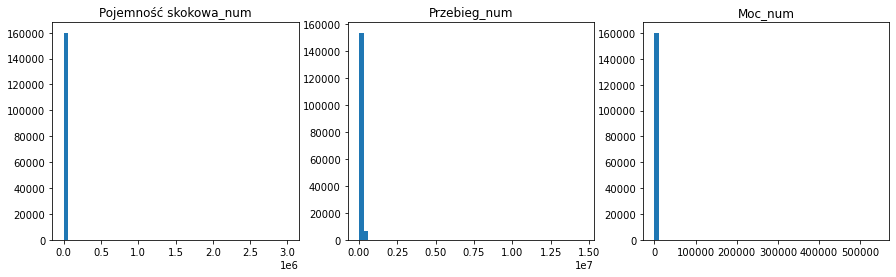

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].hist(df['Pojemność skokowa_num'], bins=50)
axs[0].set_title("Pojemność skokowa_num")
axs[1].hist(df['Przebieg_num'], bins=50)
axs[1].set_title("Przebieg_num")
axs[2].hist(df['Moc_num'], bins=50)
axs[2].set_title("Moc_num")

In [26]:
for feat_name in ["Pojemność skokowa", "Przebieg", "Moc"]:
    feats_to_check = [feat for feat in feats_to_check if feat_name not in feat]
    
parametry = ["Pojemność skokowa_num", "Przebieg_num", "Moc_num"]    
    
tymczasowe_cechy = feats_to_check + parametry

In [27]:
check_log_model(df, tymczasowe_cechy, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:45,  9.15s/it]


(8486.55339702377, 160.75129502790205)


Weight,Feature
0.3620,Rok produkcji_num
0.1132,Moc_num
0.1122,Skrzynia biegów_cat
0.0668,Napęd_cat
0.0396,features_len
0.0320,Serwisowany w ASO_cat
0.0278,Uszkodzony_cat
0.0264,Przebieg_num
0.0212,Kierownica po prawej (Anglik)_cat
0.0176,Pojemność skokowa_num


Text(0.5, 1.0, 'Moc_num_log')

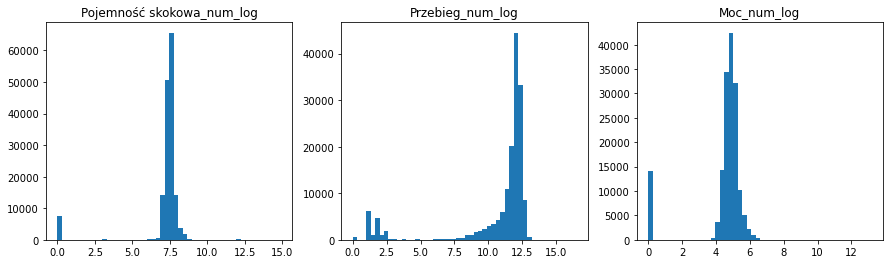

In [28]:
for feat in parametry:
    df["{}_log".format(feat)] = df[feat].map(lambda x: math.log(x + 2))

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].hist(df['Pojemność skokowa_num_log'], bins=50)
axs[0].set_title("Pojemność skokowa_num_log")
axs[1].hist(df['Przebieg_num_log'], bins=50)
axs[1].set_title("Przebieg_num_log")
axs[2].hist(df['Moc_num_log'], bins=50)
axs[2].set_title("Moc_num_log")

In [29]:
parametry_log = ["Pojemność skokowa_num_log", "Przebieg_num_log", "Moc_num_log"]
tymczasowe_cechy_log = feats_to_check + parametry_log
check_log_model(df, tymczasowe_cechy_log, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:45,  9.06s/it]


(8486.407113991187, 160.747252563511)


Weight,Feature
0.3620,Rok produkcji_num
0.1132,Moc_num_log
0.1122,Skrzynia biegów_cat
0.0668,Napęd_cat
0.0396,features_len
0.0320,Serwisowany w ASO_cat
0.0278,Uszkodzony_cat
0.0264,Przebieg_num_log
0.0212,Kierownica po prawej (Anglik)_cat
0.0176,Pojemność skokowa_num_log


In [30]:
def reset_outlires(df, feat, prc=99):
    cut_value = np.percentile(df[feat], prc)
    
    return df[feat].map(lambda x: x if x < cut_value else -1)

Text(0.5, 1.0, 'Moc_num_99')

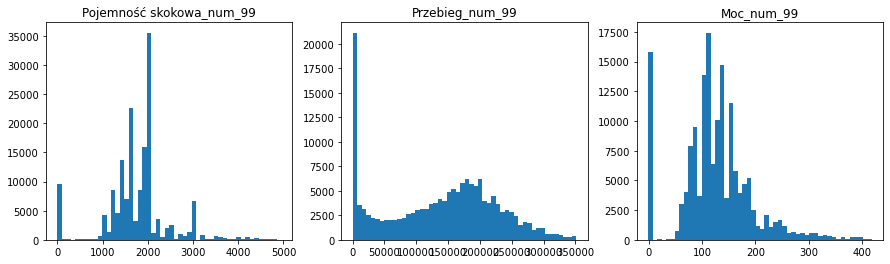

In [31]:
df["Pojemność skokowa_num_99"] = reset_outlires(df, "Pojemność skokowa_num")
df["Moc_num_99"] = reset_outlires(df, "Moc_num")
df["Przebieg_num_99"] = reset_outlires(df, "Przebieg_num")

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].hist(df['Pojemność skokowa_num_99'], bins=50)
axs[0].set_title("Pojemność skokowa_num_99")
axs[1].hist(df['Przebieg_num_99'], bins=50)
axs[1].set_title("Przebieg_num_99")
axs[2].hist(df['Moc_num_99'], bins=50)
axs[2].set_title("Moc_num_99")

In [32]:
parametry_99 = ["Pojemność skokowa_num_99", "Przebieg_num_99", "Moc_num_99"]
tymczasowe_cechy_99 = feats_to_check + parametry_99

In [33]:
check_log_model(df, tymczasowe_cechy_99, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:46,  9.30s/it]


(8693.138190777066, 155.28014418326447)


Weight,Feature
0.3908,Rok produkcji_num
0.1767,Napęd_cat
0.1043,Skrzynia biegów_cat
0.0493,Moc_num_99
0.0417,features_len
0.0241,Uszkodzony_cat
0.0226,Bezwypadkowy_cat
0.0154,Kierownica po prawej (Anglik)_cat
0.0151,Pojemność skokowa_num_99
0.0148,Typ_cat


Text(0.5, 1.0, 'Moc_num_99_log')

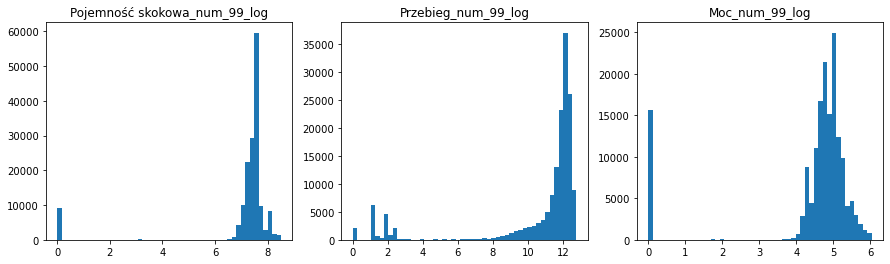

In [34]:
feats_to_log = ["Pojemność skokowa_num_99", "Przebieg_num_99", "Moc_num_99"]
for feat in feats_to_log:
    df["{}_log".format(feat)] = df[feat].map(lambda x: math.log(x + 2))

fig, axs = plt.subplots(1, 3, figsize=(15,4))
axs[0].hist(df['Pojemność skokowa_num_99_log'], bins=50)
axs[0].set_title("Pojemność skokowa_num_99_log")
axs[1].hist(df['Przebieg_num_99_log'], bins=50)
axs[1].set_title("Przebieg_num_99_log")
axs[2].hist(df['Moc_num_99_log'], bins=50)
axs[2].set_title("Moc_num_99_log")

In [35]:
parametry_99_log = ["Pojemność skokowa_num_99_log", "Przebieg_num_99_log", "Moc_num_99_log"]
tymczasowe_cechy_log_99 = feats_to_check + parametry_99_log

In [36]:
check_log_model(df, tymczasowe_cechy_log_99, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), show_eli5=True)

5it [00:46,  9.24s/it]


(8693.168276727107, 155.23554298188088)


Weight,Feature
0.3908,Rok produkcji_num
0.1767,Napęd_cat
0.1043,Skrzynia biegów_cat
0.0493,Moc_num_99_log
0.0417,features_len
0.0241,Uszkodzony_cat
0.0226,Bezwypadkowy_cat
0.0154,Kierownica po prawej (Anglik)_cat
0.0151,Pojemność skokowa_num_99_log
0.0148,Typ_cat


## Najlepszy wynik zostal uzyskany dla logartymow z cech

In [37]:
final_feats = tymczasowe_cechy_log

## Dobór Parametrów dla modelu metoda prób i błedów

In [38]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.3, random_state=0), show_eli5=False)

5it [00:46,  9.30s/it]


(8486.407113991187, 160.747252563511)

In [39]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.2, random_state=0), show_eli5=False)

5it [00:46,  9.28s/it]


(8700.987623569867, 107.75431645451333)

In [40]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.1, random_state=0), show_eli5=False)

5it [00:46,  9.32s/it]


(9794.151986439996, 360.7758923715259)

In [41]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.4, random_state=0), show_eli5=False)

5it [00:46,  9.35s/it]


(8325.095606536828, 191.45061852019307)

In [42]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=5, n_estimators=50, learning_rate=0.5, random_state=0), show_eli5=False)

5it [00:45,  9.20s/it]


(8367.636934984661, 114.18373226835948)

In [43]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=5, n_estimators=100, learning_rate=0.4, random_state=0), show_eli5=False)

5it [01:30, 18.06s/it]


(7804.054306352268, 177.11939257217296)

In [44]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=5, n_estimators=200, learning_rate=0.4, random_state=0), show_eli5=False)

5it [02:59, 35.86s/it]


(7358.278143411674, 151.4293926504244)

In [45]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=5, n_estimators=300, learning_rate=0.4, random_state=0), show_eli5=False)

5it [04:28, 53.67s/it]


(7185.931466118226, 151.26997796762302)

In [46]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=5, n_estimators=500, learning_rate=0.4, random_state=0), show_eli5=False)

5it [07:30, 90.11s/it]


(7003.753055877378, 155.12976167636418)

In [48]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=5, n_estimators=700, learning_rate=0.4, random_state=0), show_eli5=False)

5it [10:29, 125.96s/it]


(6934.013679177287, 162.35451903521434)

In [49]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=5, n_estimators=1000, learning_rate=0.4, random_state=0), show_eli5=False)

5it [14:48, 177.64s/it]


(6906.596880984542, 156.7208974495064)

In [50]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=6, n_estimators=1000, learning_rate=0.4, random_state=0), show_eli5=False)

5it [17:35, 211.12s/it]


(6971.514259227864, 208.34730065014094)

In [51]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=4, n_estimators=1000, learning_rate=0.4, random_state=0), show_eli5=False)

5it [11:40, 140.07s/it]


(6880.4596360494525, 106.59400677717977)

In [52]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=4, n_estimators=1000, learning_rate=0.3, random_state=0), show_eli5=False)

5it [12:49, 153.96s/it]


(6784.4018116911375, 157.86991734968967)

In [53]:
check_log_model(df, final_feats, xgb.XGBRegressor(max_depth=4, n_estimators=1000, learning_rate=0.5, random_state=0), show_eli5=False)

5it [11:48, 141.77s/it]


(6992.039292954782, 105.55857896339904)

## Submit

In [54]:
df_train = df[ ~df["price_value"].isnull() ].copy()
df_test = df[ df["price_value"].isnull() ].copy()

X_train = df_train[final_feats]
y_train = df_train["price_value"]
y_log_train = np.log(y_train)

X_test = df_test[final_feats]

model = xgb.XGBRegressor(max_depth=4, n_estimators=1000, learning_rate=0.3, random_state=0)
model.fit(X_train, y_log_train)
y_log_pred = model.predict(X_test)
y_pred = np.exp(y_log_pred)

df_test["price_value"] = y_pred
df_test[ ["id", "price_value"] ].to_csv("../output/submit.csv", index=False)